Reference: https://jump.dev/JuMP.jl/stable/tutorials/algorithms/tsp_lazy_constraints/

In [31]:
using JuMP
using Gurobi
using Random
using Plots

In [32]:
function generate_distance_matrix(n; random_seed = 1)
    rng = Random.MersenneTwister(random_seed)
    X = 100 * rand(rng, n) # x 좌표
    Y = 100 * rand(rng, n) # y 좌표
    d = [sqrt((X[i] - X[j])^2 + (Y[i] - Y[j])^2) for i in 1:n, j in 1:n] #distance
    return X, Y, d
end

n = 50
X, Y, d = generate_distance_matrix(n)

([23.603334566204694, 34.651701419196044, 31.27069683360675, 0.790928339056074, 48.86128300795012, 21.096820215853597, 95.1916339835734, 99.99046588986135, 25.166218303197184, 98.66663668987997  …  37.097066286146884, 89.41659192657593, 64.80537482231894, 41.70393538841062, 14.456554241360564, 62.24031828206811, 87.23344353741976, 52.49746566167794, 24.159060827129643, 88.48369255734127], [44.08974233731111, 40.467263869902006, 73.67868019103597, 95.38034231508577, 9.518559239746228, 51.967533179373014, 1.3540332577443914, 30.33988122056488, 70.25571355154578, 59.65370068827476  …  22.515104100350246, 28.616914065436294, 30.91439610705362, 17.03908213526897, 14.716190329632184, 23.006281697084184, 9.292924093459032, 68.14146962328581, 76.2276463170743, 33.908123311767135], [0.0 11.627070153960565 … 32.14270840936651 65.67439546002201; 11.627070153960565 0.0 … 37.267954858863774 54.2301170454086; … ; 32.14270840936651 37.267954858863774 … 0.0 76.997404336926; 65.67439546002201 54.230117

In [33]:
function build_tsp_model(d, n)
    model = Model(Gurobi.Optimizer)
    @variable(model, x[1:n, 1:n], Bin, Symmetric)
    @objective(model, Min, sum(d .* x) / 2)
    @constraint(model, [i in 1:n], sum(x[i, :]) == 2)
    @constraint(model, [i in 1:n], x[i, i] == 0)
    return model
end

build_tsp_model (generic function with 1 method)

In [34]:
function subtour(edges::Vector{Tuple{Int,Int}}, n) # subtour 찾기
    shortest_subtour, unvisited = collect(1:n), Set(collect(1:n))
    while !isempty(unvisited)
        this_cycle, neighbors = Int[], unvisited
        while !isempty(neighbors)
            current = pop!(neighbors)
            push!(this_cycle, current)
            if length(this_cycle) > 1
                pop!(unvisited, current)
            end
            neighbors =
                [j for (i, j) in edges if i == current && j in unvisited]
        end
        if length(this_cycle) < length(shortest_subtour)
            shortest_subtour = this_cycle
        end
    end
    return shortest_subtour
end

subtour (generic function with 3 methods)

In [35]:
function selected_edges(x::Matrix{Float64}, n)
    return Tuple{Int,Int}[(i, j) for i in 1:n, j in 1:n if x[i, j] > 0.5]
end

selected_edges (generic function with 1 method)

In [36]:
subtour(x::Matrix{Float64}) = subtour(selected_edges(x, size(x, 1)), size(x, 1))
subtour(x::AbstractMatrix{VariableRef}) = subtour(value.(x))

subtour (generic function with 3 methods)

In [37]:
iterative_model = build_tsp_model(d, n)
optimize!(iterative_model) # initial solve
time_iterated = solve_time(iterative_model)
cycle = subtour(iterative_model[:x])
while 1 < length(cycle) < n
    println("Found cycle of length $(length(cycle))")
    S = [(i, j) for (i, j) in Iterators.product(cycle, cycle) if i < j]
    @constraint(
        iterative_model,
        sum(iterative_model[:x][i, j] for (i, j) in S) <= length(cycle) - 1, # add constraints : 발생한 subtour 방지
    )
    optimize!(iterative_model)
    global time_iterated += solve_time(iterative_model)
    global cycle = subtour(iterative_model[:x])
end

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-21
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 100 rows, 1275 columns and 2550 nonzeros
Model fingerprint: 0x84711a3b
Variable types: 0 continuous, 1275 integer (1275 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 2644.2295599
Presolve removed 50 rows and 50 columns
Presolve time: 0.00s
Presolved: 50 rows, 1225 columns, 2450 nonzeros
Variable types: 0 continuous, 1225 integer (1225 binary)

Root relaxation: objective 5.788817e+02, 82 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 E

In [38]:
println("Objective value: ", objective_value(iterative_model))
println("time iterated: ", time_iterated)

Objective value: 600.1850935629493
time iterated: 0.34128403663635254


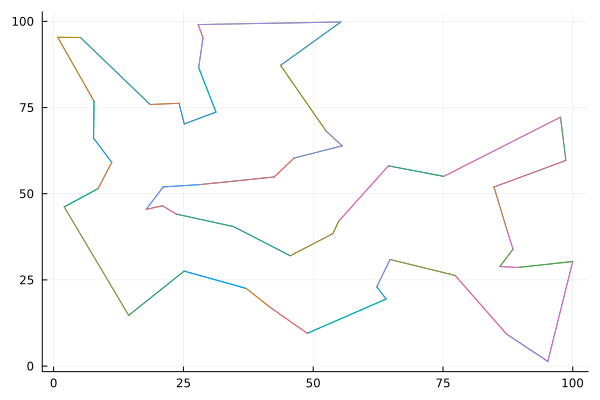

In [39]:
function plot_tour(X, Y, x)
    plot = Plots.plot()
    for (i, j) in selected_edges(x, size(x, 1))
        Plots.plot!([X[i], X[j]], [Y[i], Y[j]]; legend = false)
    end
    return plot
end

plot_tour(X, Y, value.(iterative_model[:x]))